# Process Web Json and Find Center claims

* Load Web Json file
* Extract claims and premises (data parsing)
* Find center claims

In [1]:
import json
import os

## Load web data and extract claims

In [2]:
from helper_function import count_valid_posts, get_claims
import numpy as np

In [3]:
# data_file_path = '../data/v3_70/Should-I-invest-in-Bitcoin_with_labels_v2_70.json'
data_file_path = '../data/v3_70/Would-you-get-into-a-self-driving-car.json'
with open(data_file_path, 'r') as f:
    json_content = json.load(f)
count_valid_posts(json_content)


(67, 78)

In [4]:
claims = get_claims(json_content)
print(f"get {len(claims)} claims")
claims

get 74 claims


['Yes, you would.',
 'Its a no brainer',
 'Initially the investment might be big, but the ROI is pretty awesome and worth it.',
 'You already do. It is called "taxi".',
 'I already have.',
 "I would. However, I admit that, since I don't offer a proper explanation, some here would classify me as a zealot. They would not be wrong.",
 'Absolutely.',
 'Absolutely. It will be a while before they are legal for regular people though.',
 'I don’t trust them.',
 'This is not something I want to be an early adopter with.',
 'A properly working one that can drive well? Yeah, I would.',
 'I would absolutely buy a car that drives itself.',
 'I plan to buy one as soon as the price gets in the range of the regular models.',
 "yes. maybe a slow drive at first just to be sure, but I'm confident about this technological future.",
 "I'd consider it, definitely not straight away though - will wait a few years until everything is 100% safe and secure.",
 'I would love to have a robotic driver!!',
 'A self-

## Sentiment Analysis

In [5]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_model_path = '../pretrained_models/twitter-xlm-roberta-base-sentiment'
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_path)
sentiment_config = AutoConfig.from_pretrained(sentiment_model_path)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path)


In [6]:
## get sentiment score for each sentence

preprocessed_claims = [preprocess(x) for x in claims]
sentiment_encodings = sentiment_tokenizer(preprocessed_claims, return_tensors='pt', padding=True, truncation=True, max_length=20)
with torch.no_grad():
    sentiment_output = sentiment_model(**sentiment_encodings)
sentiment_scores = sentiment_output.logits
sentiment_probability = F.softmax(sentiment_scores, dim=1).numpy()

## positive, neutral, negative
print(sentiment_config.id2label)

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [7]:
## positive, neutral, negative
sentiment_probability[:5]

array([[0.15413749, 0.43996978, 0.40589276],
       [0.954586  , 0.02734914, 0.01806478],
       [0.02884259, 0.09021665, 0.8809408 ],
       [0.035575  , 0.856702  , 0.10772295],
       [0.15311886, 0.606979  , 0.23990217]], dtype=float32)

## Get center claims

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [9]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('../pretrained_models/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('../pretrained_models/all-MiniLM-L6-v2')


In [10]:
encoded_input = tokenizer(claims, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# Normalization
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).numpy()

In [11]:
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(74, 384)

In [12]:
### using PCA method to reduce demension and do visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance =  0.21229145675897598


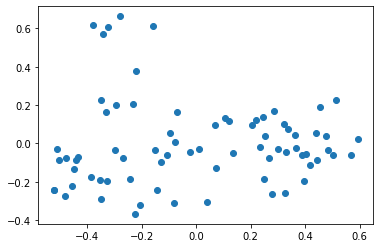

In [13]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(sentence_embeddings)
explained_variance = pca.explained_variance_ratio_
print("Explained variance = ",sum(explained_variance))
plt.scatter(x = x_pca.T[0], y=x_pca.T[1])
plt.show()

## Clustering

In [14]:
# clustering
from sklearn.cluster import SpectralClustering, AffinityPropagation

In [15]:
# use algorithms to reduce demension

pca = PCA()
sentence_embeddings_distilled = pca.fit_transform(sentence_embeddings)

In [16]:
# concate with sentiment scores
# decided not to use it
# sentence_embeddings_distilled = np.concatenate((sentence_embeddings_distilled, sentiment_probability), axis=1)
sentence_embeddings_distilled.shape

(74, 74)

In [17]:
cluster_algo = AffinityPropagation(random_state=43)
# cluster_algo = SpectralClustering(random_state=43, n_clusters=18)
# cluster = cluster_algo.fit(sentence_embeddings)
cluster = cluster_algo.fit(sentence_embeddings_distilled)
print("Clustered into {} clusters with labels {}".format(
    np.unique(cluster.labels_).shape, np.unique(cluster.labels_)))


Clustered into (10,) clusters with labels [0 1 2 3 4 5 6 7 8 9]


In [18]:
unique, count = np.unique(cluster.labels_, return_counts=True)
print(dict(zip(*np.unique(cluster.labels_, return_counts=True))))


{0: 6, 1: 1, 2: 7, 3: 4, 4: 7, 5: 6, 6: 11, 7: 7, 8: 5, 9: 20}


In [19]:
claim_clusters = {i: [] for i in range(len(np.unique(cluster.labels_)))}
for i,label in enumerate(cluster.labels_):
    claim_clusters[label].append(claims[i])
claim_clusters

{0: ['All in all, I’ll let the car drive 95% of the time, and maybe take the wheel the other 5%.',
  "I love to drive on a nice day with little or no traffic. At all other times, I'll have my car drive for me.",
  'when I’m driving on the highway no matter how long the trip is, I won’t use the cruse control.',
  'All in all, well, i would still prefer to drive to drive me car on short distance because to me, driving is a pleasure.',
  'I don’t. I value people’s lives more than the effort I lose having to drive myself.',
  'Just happens that I enjoy driving, and I’m not giving it to a machine!!'],
 1: ["In the case I've described two paragraphs above, I'm really lost as to what fact based evidence could be used to chose the human."],
 2: ['Absolutely.',
  'Yes.',
  'Yes, definitely.',
  'Yes!',
  'Yes',
  'Yes.',
  'Not yet.'],
 3: ['Absolutely. It will be a while before they are legal for regular people though.',
  'I plan to buy one as soon as the price gets in the range of the regula

In [26]:
claimCenter_polarty = {}
center_claims_relation = {}
print(sentiment_config.id2label)
for i,term in enumerate(cluster.cluster_centers_indices_):
    center_claims_relation[i] = claims[term]
    print(f"{i}:\t{claims[term]}", end='\t')
    polarity_index = np.argmax(sentiment_probability[term])
    print(sentiment_config.id2label[polarity_index], sentiment_probability[term])
    claimCenter_polarty[claims[term]] = sentiment_config.id2label[polarity_index]


{0: 'Negative', 1: 'Neutral', 2: 'Positive'}
0:	I love to drive on a nice day with little or no traffic. At all other times, I'll have my car drive for me.	Positive [0.03459552 0.1378941  0.82751036]
1:	In the case I've described two paragraphs above, I'm really lost as to what fact based evidence could be used to chose the human.	Negative [0.9041855  0.08176195 0.01405254]
2:	Yes.	Neutral [0.24485303 0.48246276 0.27268422]
3:	Yes, as soon as they work and are available at a reasonable price.	Neutral [0.02830513 0.6264308  0.345264  ]
4:	Yes - in a few years it might be safer than me driving.	Positive [0.06587382 0.31457594 0.6195503 ]
5:	No. It is too early in the technology to be able to trust the self-driving car.	Negative [0.62078047 0.3340705  0.04514893]
6:	Yes, I would.	Positive [0.09568746 0.35731435 0.5469982 ]
7:	Nope. Absolutely not!	Negative [0.63178897 0.29335687 0.07485413]
8:	Not at the time of answering.	Neutral [0.20982097 0.74186265 0.04831635]
9:	Yes, I really would 

## Assign center claims

In [21]:
count = 0
for i in json_content['answers']:
    if i:
        for j in i['claim']:
            claim_center = claims[cluster.cluster_centers_indices_[
                cluster.labels_[count]]]
            j['claimCenter'] = claim_center
            j['claimSentiment'] = claimCenter_polarty[claim_center]
            count += 1


In [22]:
claim_center

'Nope. Absolutely not!'

In [23]:
# output_file_path = '../data/v3_70_filled/Should-I-invest-in-Bitcoin_with_labels_v3_70_filled.json'
output_file_path = '../data/v3_70_filled/Would-you-get-into-a-self-driving-car_v3_70_filled.json'
with open(output_file_path, 'w') as f:
    json.dump(json_content, fp=f)


In [32]:
with open("../data/newest_data(rolling update)/claim center and statistics/automos driving/claim_clusters.json", 'w') as f:
    json.dump(claim_clusters, f, indent=4)
with open('../data/newest_data(rolling update)/claim center and statistics/automos driving/stance_count.json', 'w') as f:
    inv_map = {}
    for k, v in claimCenter_polarty.items():
        v = v.lower()
        inv_map[v] = inv_map.get(v, []) + [k]
    json.dump(inv_map,fp=f, indent=4)
with open('../data/newest_data(rolling update)/claim center and statistics/automos driving/center_claims_relation.json', 'w') as f:
    json.dump(center_claims_relation, f, indent=4)


{0: "I love to drive on a nice day with little or no traffic. At all other times, I'll have my car drive for me.",
 1: "In the case I've described two paragraphs above, I'm really lost as to what fact based evidence could be used to chose the human.",
 2: 'Yes.',
 3: 'Yes, as soon as they work and are available at a reasonable price.',
 4: 'Yes - in a few years it might be safer than me driving.',
 5: 'No. It is too early in the technology to be able to trust the self-driving car.',
 6: 'Yes, I would.',
 7: 'Nope. Absolutely not!',
 8: 'Not at the time of answering.',
 9: 'Yes, I really would like to have a self-driving car.'}